# Message-passing graph neural network for hit classification

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

In [2]:
# System imports
from __future__ import print_function
from __future__ import division
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Prepare the dataset

I'm deciding what I want to do as I go along.

I want to demonstrate some kind of binary hit classification.
I could use the 10-track artificial samples from the segment classification notebook,
or I could try to build more realistic sub-graphs from real events. I think the more interesting case is the latter one.

So the procedure will roughly be:
- select all barrel hits and remove duplicates
- select good target track samples (perfect 10-layers)
- for each track, select a fixed number of hits in the neighborhood of the true hits

I think I've implemented most of this already in other notebooks.
- selecting closest hits was done in tree_search/RNNHitClassifier.ipynb

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=hits.index, dtype=np.int8)
    vid_groups = hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    # Select the columns we need
    hits = (hits[['evtid', 'barcode', 'r', 'phi', 'z']]
            .assign(volume=volume, layer=layer))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

def select_signal_hits(hits, n_layer_hits=5, n_layers=10):
    # Select events that have enough hits per layer
    hits = (hits.groupby('evtid')
            .filter(lambda x: (x.groupby('layer').size() > n_layer_hits).all()))
    # Filter tracks that hit every layer
    hits = (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: len(x.layer.unique()) == n_layers))
    return hits

In [5]:
input_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
#input_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [6]:
n_files = 5

all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [7]:
%%time

n_workers = 5
pool = mp.Pool(processes=n_workers)

hits = process_hits_files(hits_files, pool)
print('Applying selections')
hits = pool.map(select_hits, hits)

pool.close()

# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Applying selections
CPU times: user 226 ms, sys: 188 ms, total: 414 ms
Wall time: 1min 31s


In [8]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta_phi_distance(eta1, eta2, phi1, phi2):
    deta = eta2 - eta1
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

def calc_distance(r1, r2, z1, z2, phi1, phi2):
    eta1 = calc_eta(r1, z1)
    eta2 = calc_eta(r2, z2)
    return calc_eta_phi_distance(eta1, eta2, phi1, phi2)

In [9]:
%%time

# Select signal track hits
sig_hits = select_signal_hits(hits)
print(sig_hits.shape)

(650210, 7)
CPU times: user 46.7 s, sys: 76.9 ms, total: 46.8 s
Wall time: 46.8 s


In [10]:
# Get the signal track keys
sig_keys = sig_hits[['evtid', 'barcode']].drop_duplicates().values
evt_groups = hits.groupby('evtid')

In [11]:
feature_names = ['r', 'phi', 'z']
feature_scale = np.array([1000., np.pi, 1000.])

n_samples = sig_keys.shape[0]
n_features = len(feature_names) + 1

n_det_layers = 10
n_layer_hits = 5
n_seed_layers = 3
n_hits = n_det_layers * n_layer_hits
n_edges = n_layer_hits**2 * (n_det_layers - 1)

edge_idx = np.arange(n_edges)

In [12]:
print('Preparing', n_samples, 'samples, each with', n_hits, 'nodes and', n_edges, 'edges')

Preparing 65021 samples, each with 50 nodes and 225 edges


In [13]:
# Prepare the dataset tensors
full_X = np.zeros((n_samples, n_hits, n_features), dtype=np.float32)
full_Ri = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_Ro = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_y = np.zeros((n_samples, n_hits), dtype=np.uint8)

In [14]:
%%time

# Loop over samples
for i in range(n_samples):
    eid, pid = sig_keys[i]    
    # Select all the hits from this event
    evt_hits = evt_groups.get_group(eid)
    # Select the true, signal track hits
    trk_hits = evt_hits[evt_hits.barcode == pid]
    
    # Temporary error check
    assert np.all(trk_hits.layer.values == np.arange(n_det_layers)), trk_hits.layer.values
    
    # Loop over detector layers to select candidate hits
    cand_idx = []
    for j in range(n_det_layers):
        lay_hits = evt_hits[evt_hits.layer == j]        
        # Compute hit distances relative to the true hit
        trk_hit = trk_hits.iloc[j]
        trk_eta = calc_eta(trk_hit.r, trk_hit.z)
        lay_eta = calc_eta(lay_hits.r, lay_hits.z)
        d = calc_eta_phi_distance(trk_eta, lay_eta, trk_hit.phi, lay_hits.phi)
        # Take the closest hits
        cand_idx.append(d.sort_values()[:n_layer_hits].index)

    # Combine the candidates
    cand_hits = pd.concat([evt_hits.loc[idx] for idx in cand_idx])
    # Center phi on the first true hit
    phi0 = trk_hits.phi.iloc[0]
    cand_hits.phi = calc_dphi(phi0, cand_hits.phi)
    # Fill the labels
    full_y[i] = (cand_hits.barcode == pid)
    # Fill the features
    full_X[i, :, :-1] = cand_hits[feature_names] / feature_scale
    cand_layers = cand_hits.layer.values
    seed_idx = (cand_layers < n_seed_layers)
    full_X[i, seed_idx, -1] = full_y[i, seed_idx]
    # Select adjacent-layer hit pairs.
    adj_idx = np.stack((np.where((cand_layers[None,:] - cand_layers[:,None]) == 1)), axis=1)
    # Fill the adjacency matrices
    full_Ri[i, adj_idx[:,1], edge_idx] = 1
    full_Ro[i, adj_idx[:,0], edge_idx] = 1

CPU times: user 1h 23min 47s, sys: 18.1 s, total: 1h 24min 5s
Wall time: 1h 24min 4s


## Visualize one sample

In [15]:
def draw_sample(X, Ri, Ro, y, cmap='bwr'):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    # TODO: color by seed label
    ax0.scatter(X[:,2], X[:,0], c=y, cmap=cmap)
    ax1.scatter(X[:,1], X[:,0], c=y, cmap=cmap)
    
    # Draw the segments
    for j in range(Ri.shape[1]):
        seg_args = dict(c='k', alpha=0.2)
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    #ax1.set_xlim(-np.pi, np.pi)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

<IPython.core.display.Javascript object>


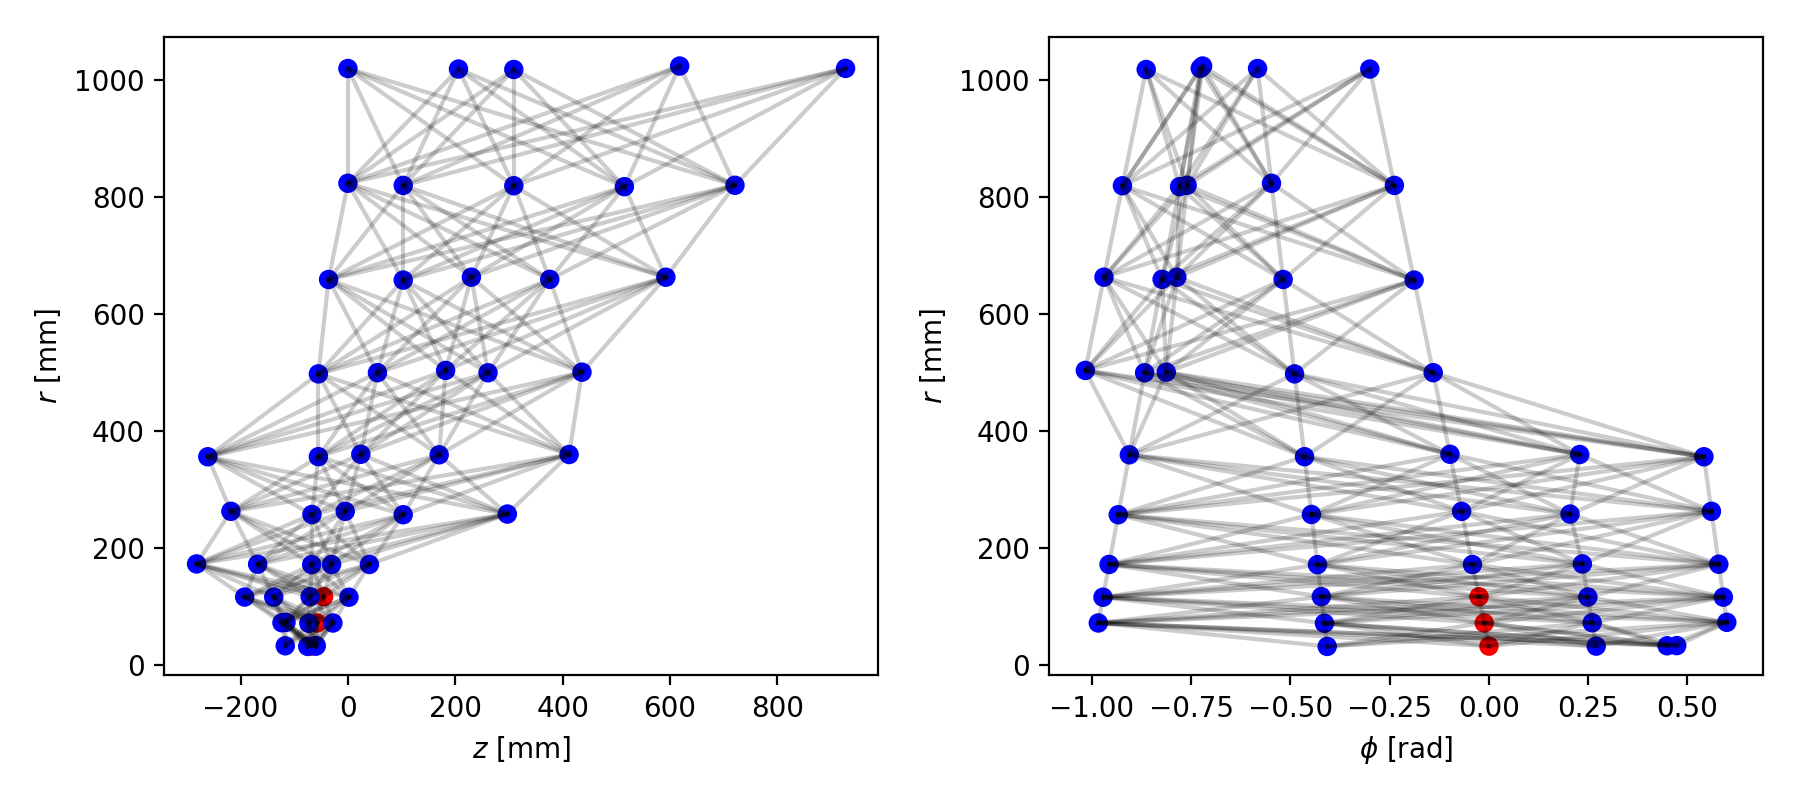

In [16]:
i = 0
X = full_X[i,:,:-1]*feature_scale
y = full_X[i,:,-1]
draw_sample(X, full_Ri[i], full_Ro[i], y)

## Define the model

In [17]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

In [18]:
class NodeClassifier(nn.Module):
    """
    A message-passing graph neural network model which performs
    binary classification of nodes.
    """
    def __init__(self, input_dim=4, hidden_dim=8, n_iters=1, hidden_activation=nn.Tanh):
        super(NodeClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the output network
        self.output_network = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final output network
        return self.output_network(H).squeeze(-1)

## Train the model

In [19]:
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X = np_to_torch(X[j:j+batch_size], volatile=volatile)
            batch_Ri = np_to_torch(Ri[j:j+batch_size], volatile=volatile)
            batch_Ro = np_to_torch(Ro[j:j+batch_size], volatile=volatile)
            batch_y = np_to_torch(y[j:j+batch_size], volatile=volatile)
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

In [20]:
# Model config
hidden_dim = 64
n_iters = 7

# Training config
batch_size = 32
n_epochs = 16
valid_frac = 0.2
test_frac = 0.2

In [21]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test // batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(39008, 12992, 12992, 64992)

In [22]:
%%time

# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(full_X, full_Ri, full_Ro, full_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

CPU times: user 451 ms, sys: 868 ms, total: 1.32 s
Wall time: 1.34 s


In [23]:
print('Train shapes:', train_X.shape, train_Ri.shape, train_Ro.shape, train_y.shape)
print('Valid shapes:', valid_X.shape, valid_Ri.shape, valid_Ro.shape, valid_y.shape)
print('Test shapes: ', test_X.shape, test_Ri.shape, test_Ro.shape, test_y.shape)

Train shapes: (39037, 50, 4) (39037, 50, 225) (39037, 50, 225) (39037, 50)
Valid shapes: (12992, 50, 4) (12992, 50, 225) (12992, 50, 225) (12992, 50)
Test shapes:  (12992, 50, 4) (12992, 50, 225) (12992, 50, 225) (12992, 50)


In [24]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False,
                                n_samples=n_valid, batch_size=batch_size)
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                               n_samples=n_test, batch_size=batch_size)

In [25]:
# Construct the model
model = NodeClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-03-21 10:38:04.869145 Model: 
NodeClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=4, out_features=64)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=136, out_features=64)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=204, out_features=64)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64)
      (3): Tanh()
    )
  )
  (output_network): Sequential(
    (0): Linear(in_features=68, out_features=1)
    (1): Sigmoid()
  )
)
2018-03-21 10:38:04.878519 Parameters: 26502


In [26]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches)

2018-03-21 10:38:04.882789 Epoch 0
2018-03-21 10:41:46.070139   training loss 0.238 time 221.187s
2018-03-21 10:42:25.114242   validate loss 0.136
2018-03-21 10:42:25.114574 Epoch 1
2018-03-21 10:46:00.031466   training loss 0.138 time 214.916s
2018-03-21 10:46:39.237999   validate loss 0.138
2018-03-21 10:46:39.238835 Epoch 2
2018-03-21 10:50:18.323410   training loss 0.11 time 219.084s
2018-03-21 10:50:57.483554   validate loss 0.138
2018-03-21 10:50:57.484024 Epoch 3
2018-03-21 10:54:31.788090   training loss 0.0905 time 214.304s
2018-03-21 10:55:13.191727   validate loss 0.0909
2018-03-21 10:55:13.192001 Epoch 4
2018-03-21 10:59:00.739957   training loss 0.073 time 227.548s
2018-03-21 10:59:42.846766   validate loss 0.0736
2018-03-21 10:59:42.847440 Epoch 5
2018-03-21 11:03:31.395940   training loss 0.0622 time 228.548s
2018-03-21 11:04:13.241900   validate loss 0.0611
2018-03-21 11:04:13.242349 Epoch 6
2018-03-21 11:07:49.866776   training loss 0.0548 time 216.624s
2018-03-21 11:0

### Loss curves

<IPython.core.display.Javascript object>


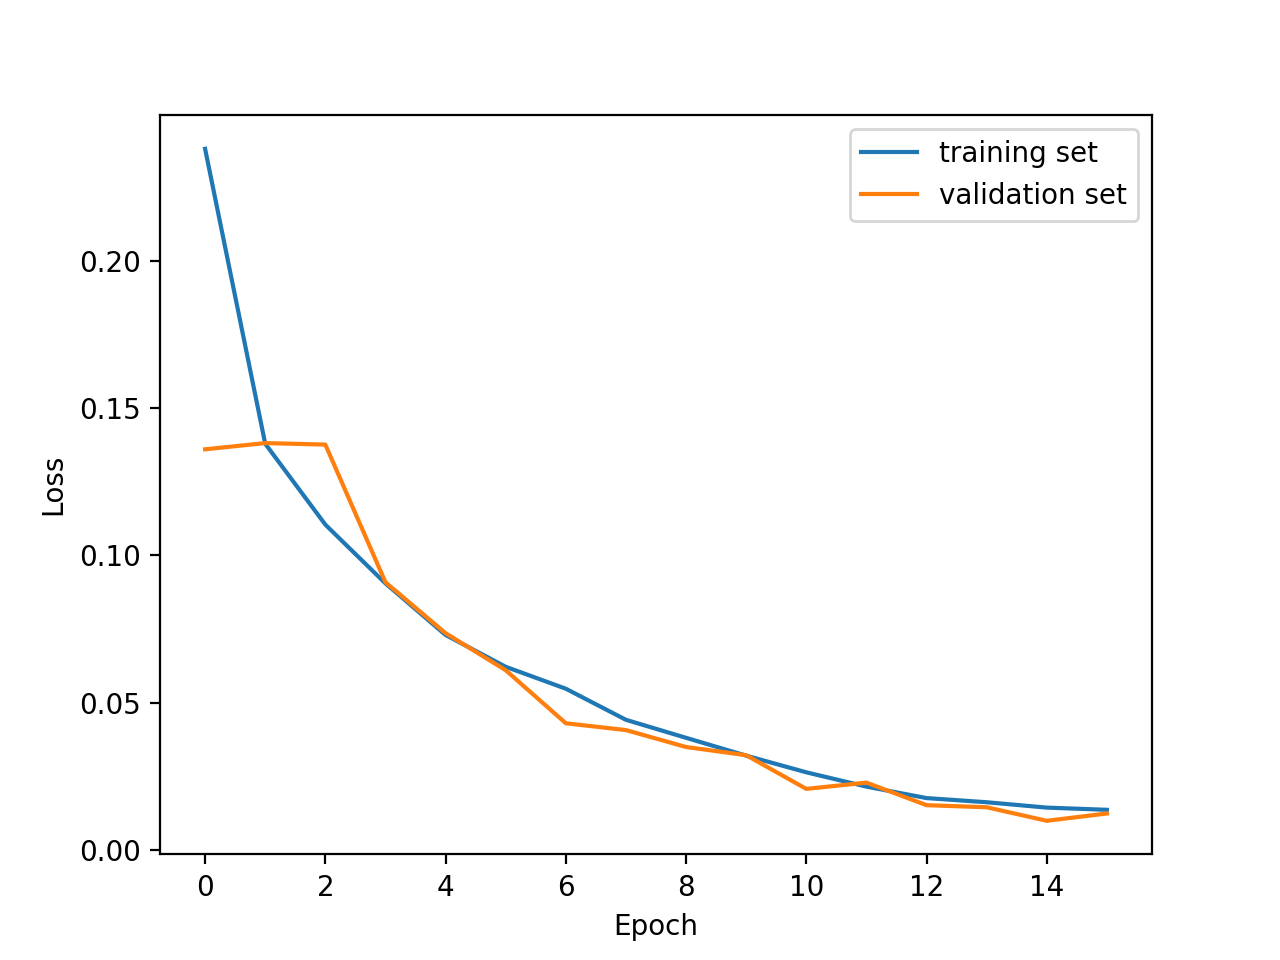

In [27]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate on the test set

In [28]:
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

In [29]:
flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.5
Accuracy:  0.9942
Precision: 0.9918
Recall:    0.9793


In [30]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

<IPython.core.display.Javascript object>


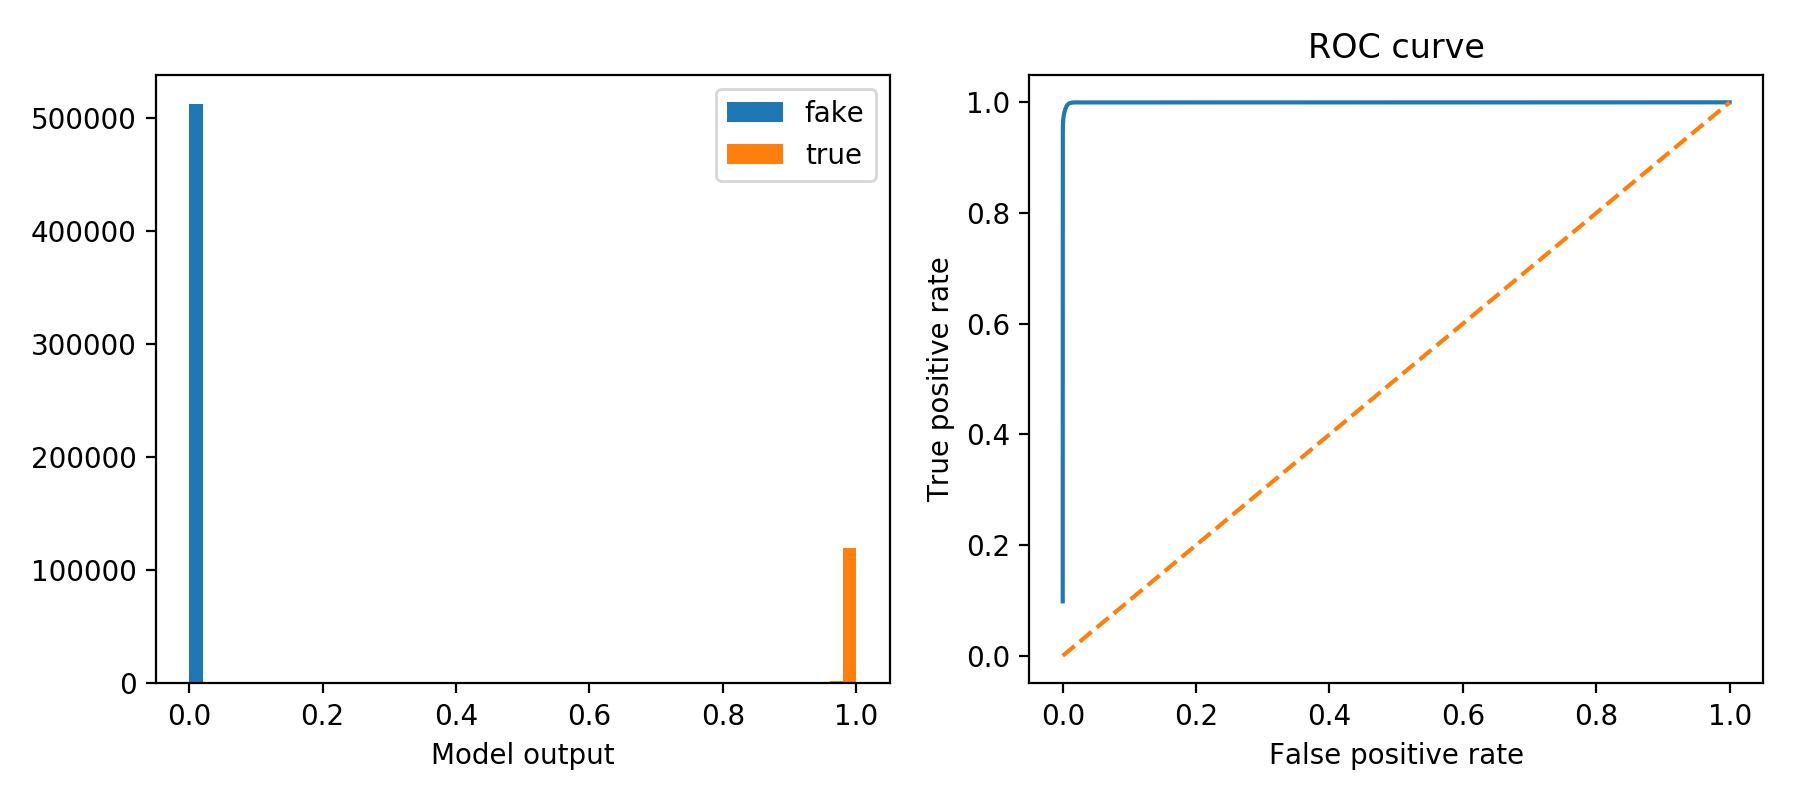

In [31]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

accuracy 1.000, precision 1.000, recall 1.000


<IPython.core.display.Javascript object>


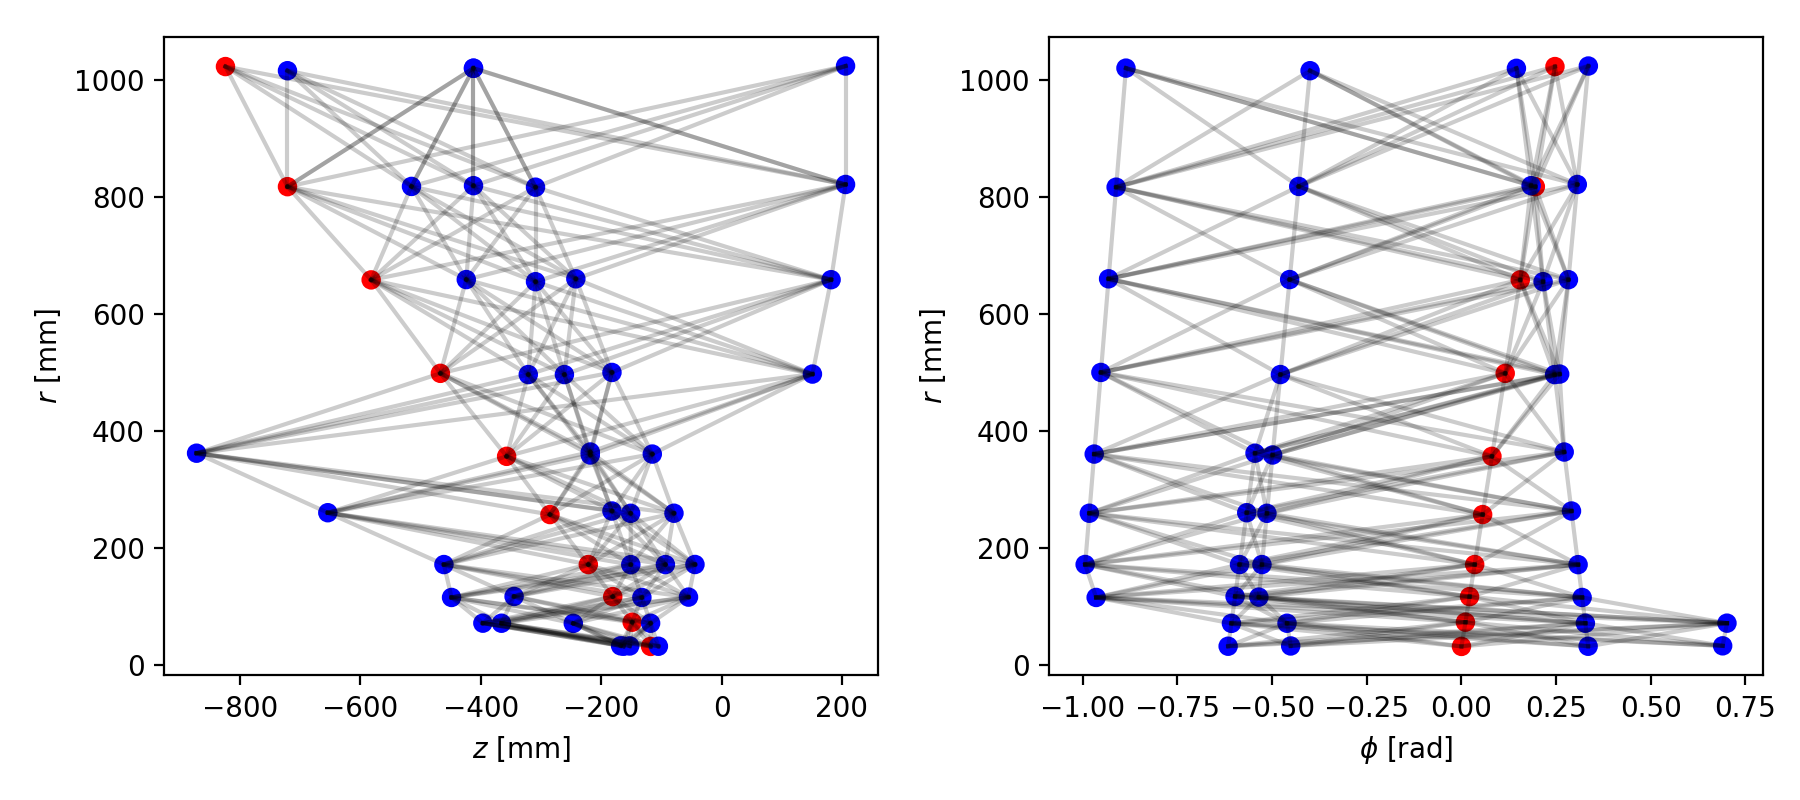

accuracy 1.000, precision 1.000, recall 1.000


<IPython.core.display.Javascript object>


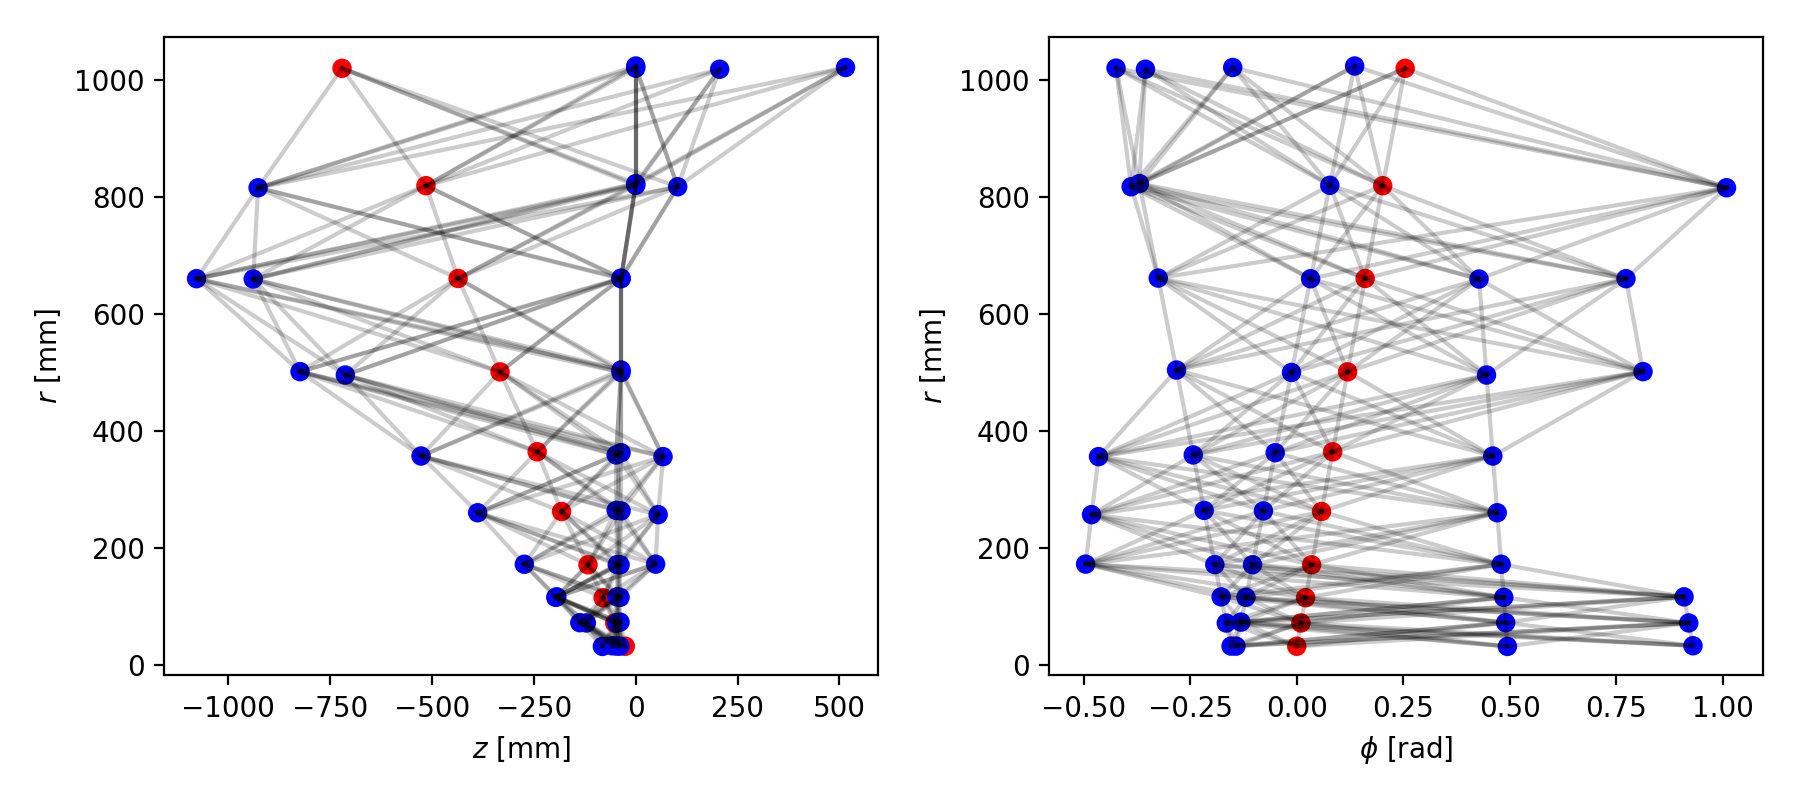

accuracy 0.960, precision 0.900, recall 0.900


<IPython.core.display.Javascript object>


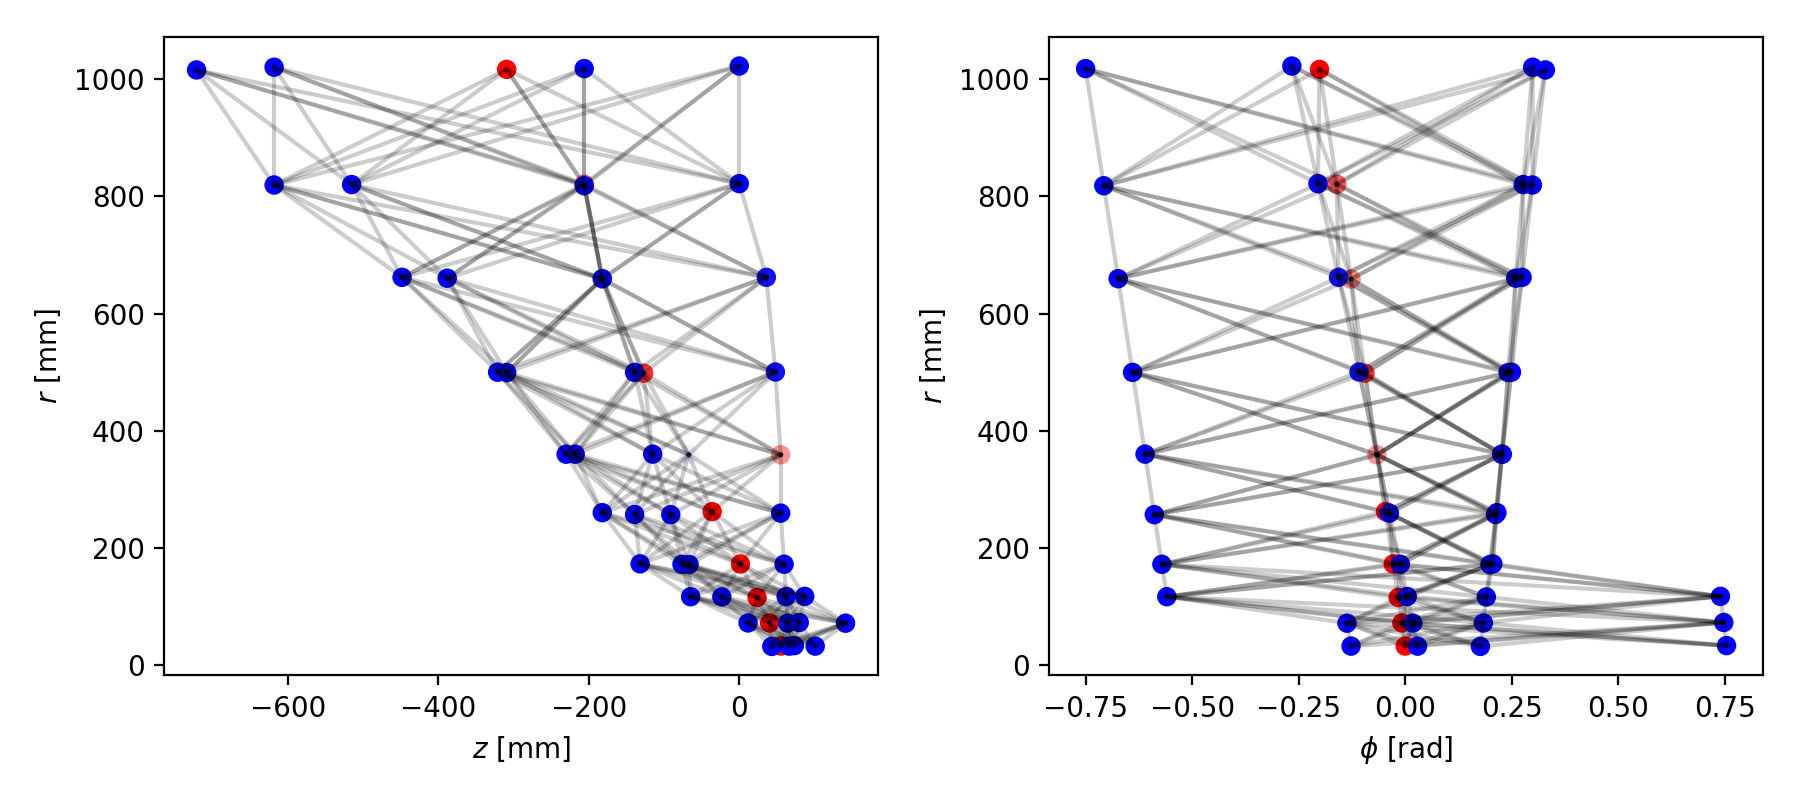

accuracy 1.000, precision 1.000, recall 1.000


<IPython.core.display.Javascript object>


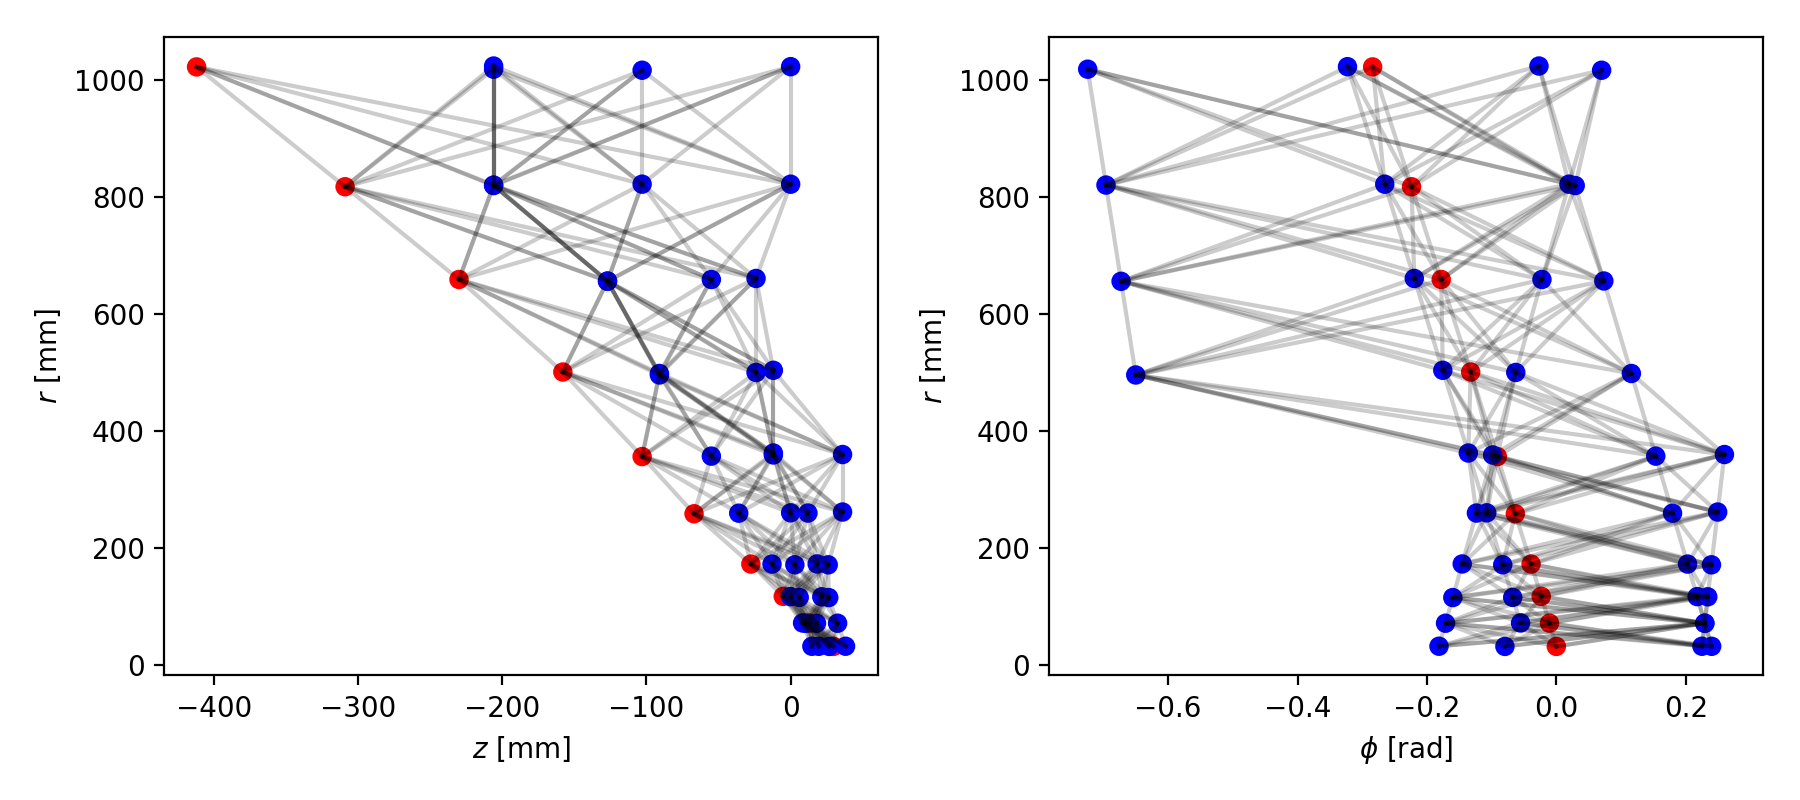

In [32]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i,:,:-1]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i]);

## Discussion

Performance is looking pretty good!